# Korrelationsanalyse #

## Inhalt ##

1. [Korrelationsanalyse auf den vorverarbeiteten Daten *ohne* Encoding](#1) \
  1.1 [Korrelationsmatrix für alle numerischen Features](#1_1) \
  1.2 [Interessanten Ausschnitt der Matrix seperat darstellen](#1_2) \
  1.3 [Höchste (positive und negative) Korrelationen](#1_3) \
    1.3.1 [Interessante Korrelationen](#1_3_1) \
  1.4 [Interessante Korrelationen genauer untersuchen](#1_4) \
    1.4.1 [Korrelationsdiagramme zu den Features die mit Malen Schauspiel Musik Museen zu tun haben](#1_4_1) \
    1.4.2 [Alter vs. Sprachnachrichten](#1_4_2)
2. [Korrelationsanalyse auf den vorverarbeiteten Daten *mit* Encoding](#2) \
  2.1 [_Einschub:_ Erkenntnisse vor Einbau des Variance-Filters](#2_1) \
  2.2 [Analyse der Korrelationen mit Encoding *und* Variance Filter](#2_2) \
    2.2.1 [Ausschnitt der Matrix mit hoher Korrelation in den encodeten Features](#2_2_1) \
    2.2.2 [Höchste (positive und negative) Korrelationen suchen](#2_2_2) \

## Imports/Setup ##

In [194]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from IPython.display import HTML

In [195]:
%store -r columns
%store -r columns_encoded
%store -r data
%store -r data_encoded

columns = columns
columns_encoded = columns_encoded
data = data
data_encoded = data_encoded

# 1. Korrelationsanalyse auf den vorverarbeiteten Daten *ohne* Encoding <a name="1"></a>

In diesem Kapitel werden die vorverarbeiteten Daten, allerdings ohne die One-Hot-encodeten Features untersucht.

## 1.1 Korrelationsmatrix für alle numerischen Features <a name="1_1"></a>

Für einen ersten Überblick wird eine Korrelationsmatrix aller numerischen Features erstellt.

<Axes: >

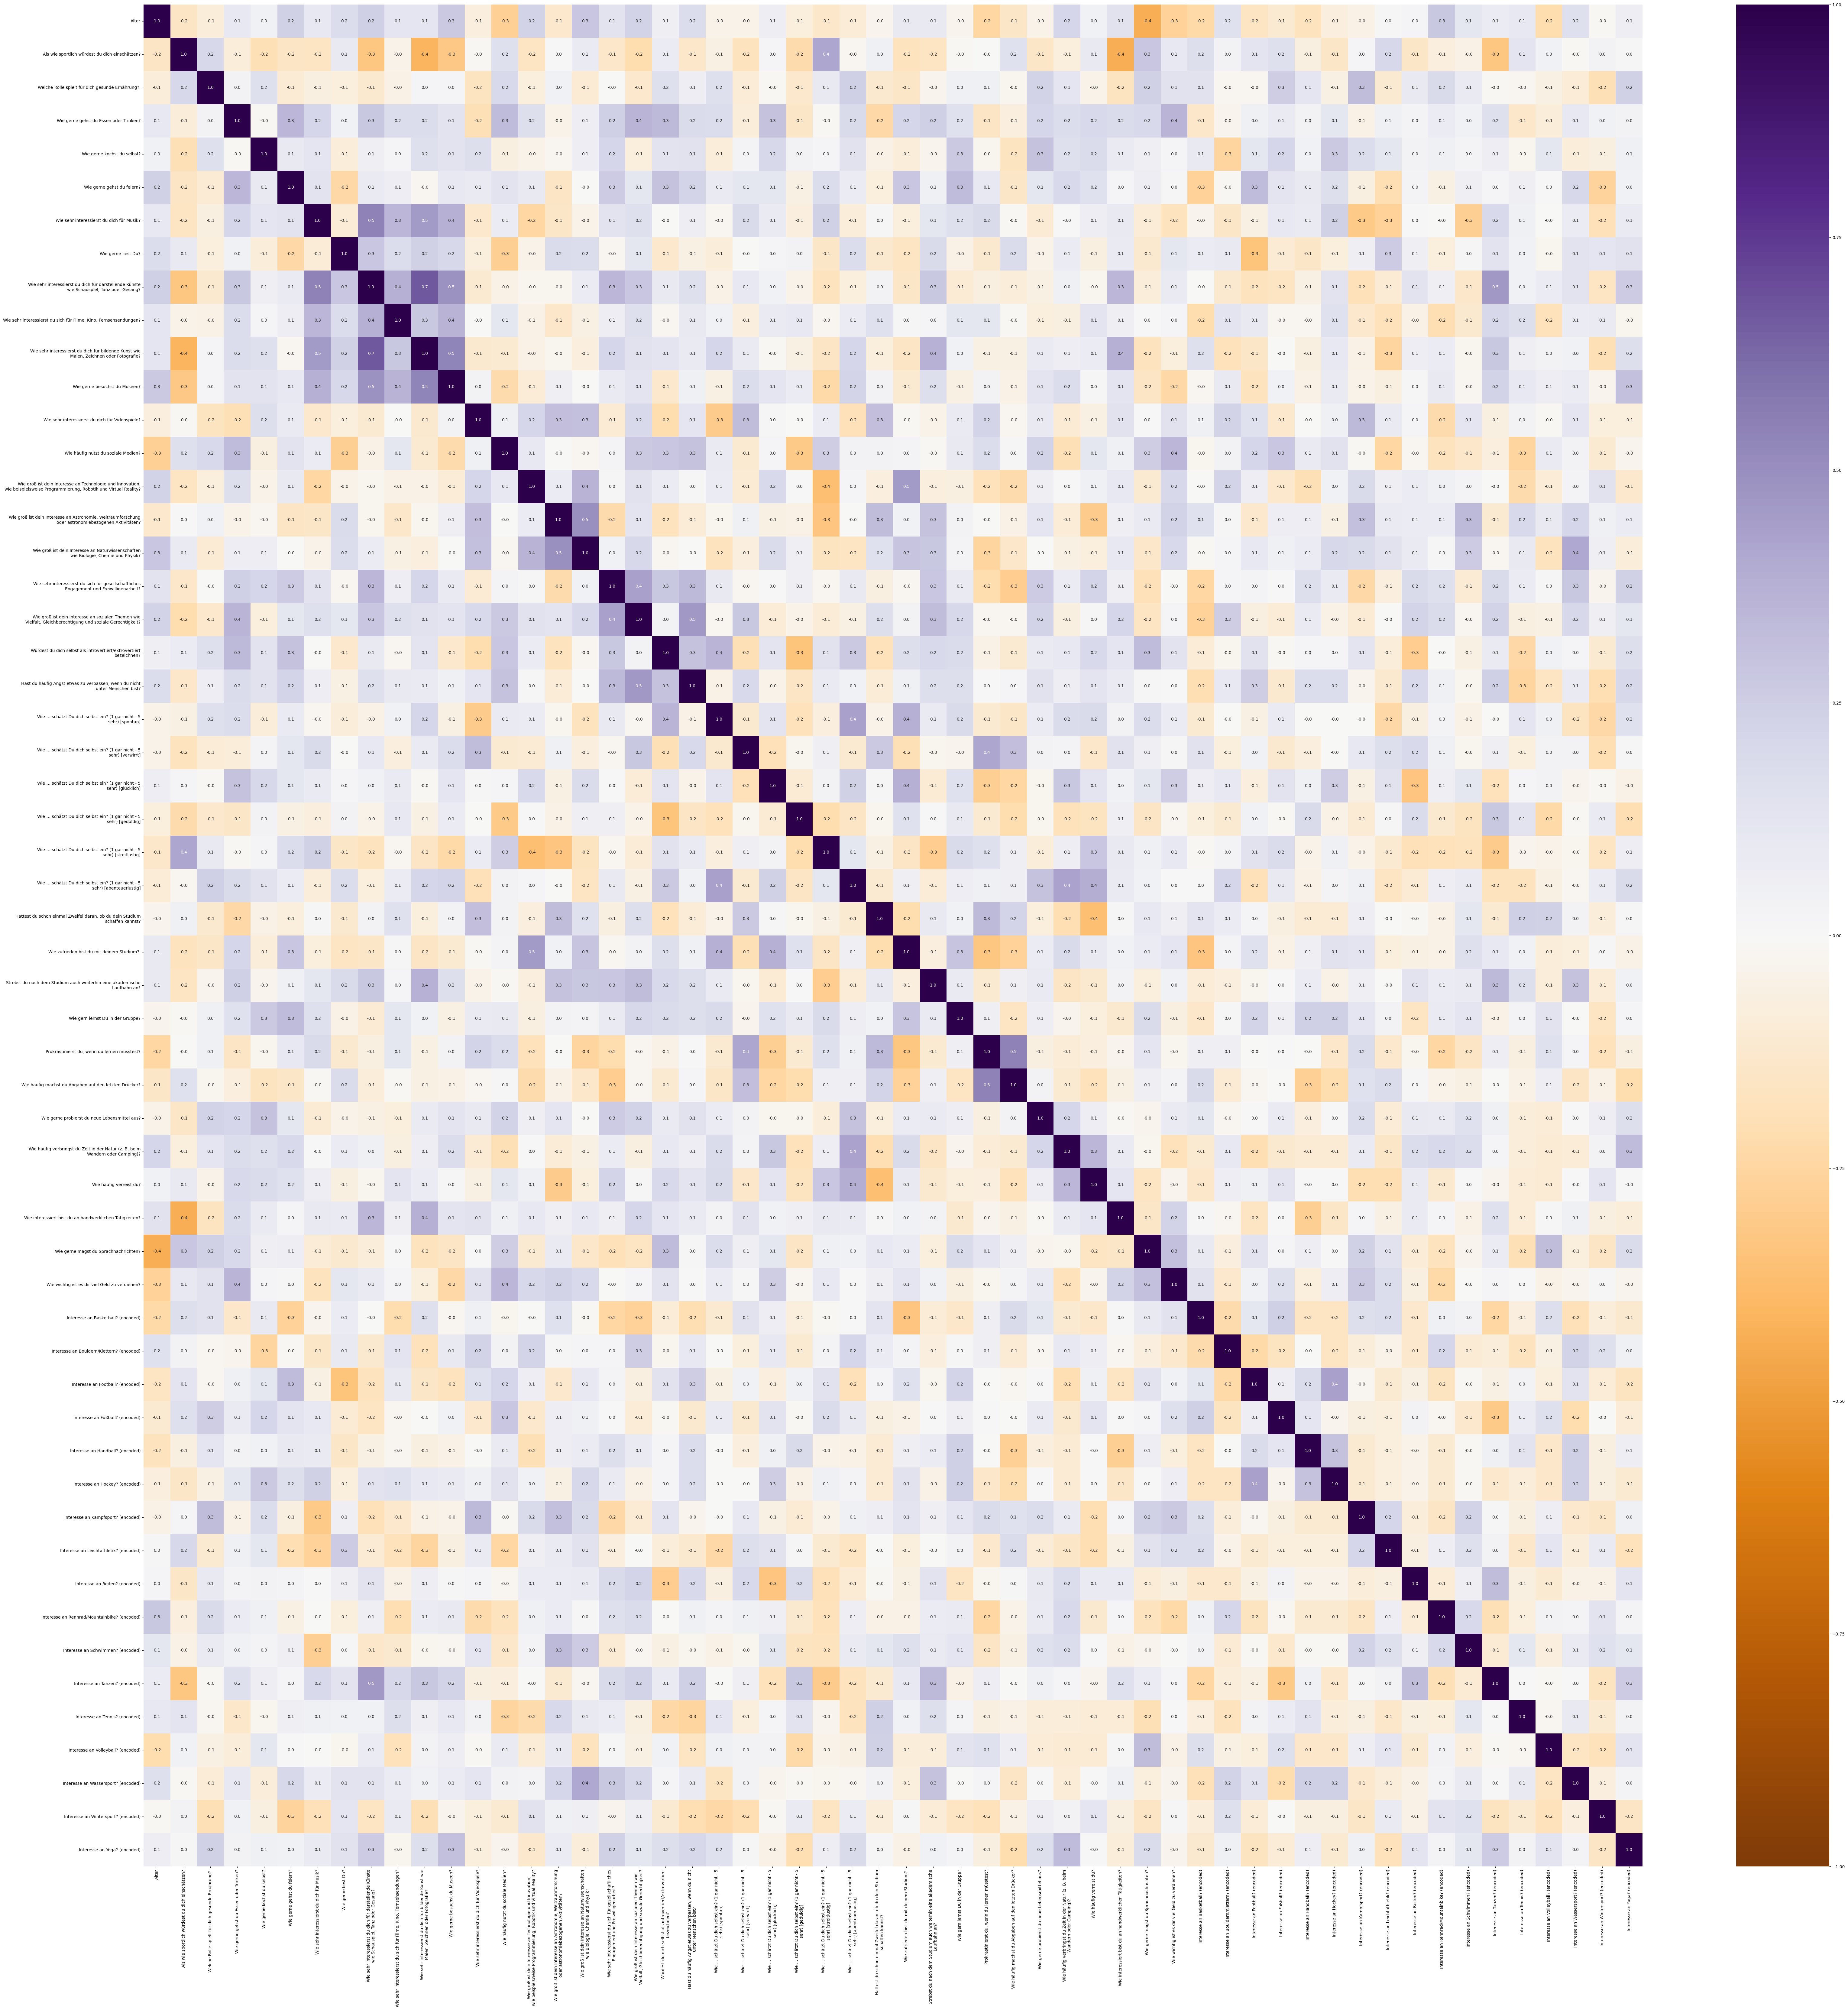

In [196]:
fig, ax = plt.subplots(figsize=(80, 80))

corr_matrix = data.corr(numeric_only=True)

sb.heatmap(corr_matrix, annot=True, cmap="PuOr",fmt=".1f", vmin=-1, vmax=1)

Auch wenn die Matrix so kaum ablesbar ist, gibt sie zumindest eine Idee, welche Bereiche der Matrix man sich genauer anschauen sollte. Es scheint allerdings keine extrem hohen Korrelationen zu geben, die auf einen direkten Zusammenhang zweier Features schließen lassen.

## 1.2 Interessanten Ausschnitt der Matrix seperat darstellen <a name="1_2"></a>

Rund um "Malen", "Schauspiel", "Musik" und "Museumsbesuche" scheint es einige Korrelationen zu geben. Daher bietet es sich an, diesen Abschnitt noch einmal genauer anzuschauen.

<Axes: >

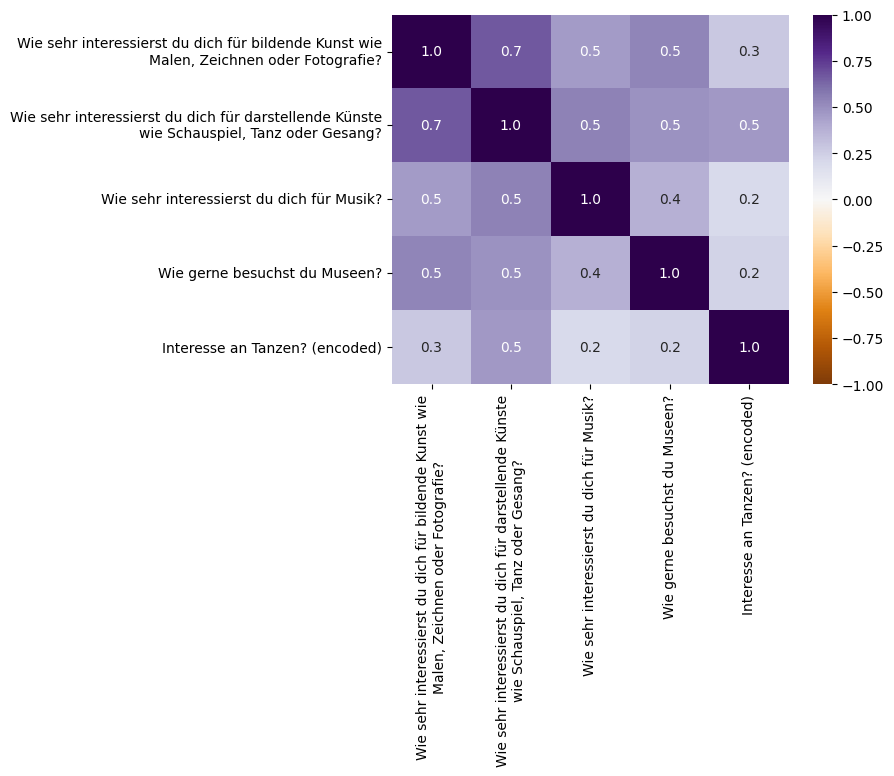

In [197]:
corr_creativity_features = corr_matrix.loc[[columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche, columns.sportarten_Tanzen], [columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche, columns.sportarten_Tanzen]]
sb.heatmap(corr_creativity_features, annot=True, cmap="PuOr",fmt=".1f", vmin=-1, vmax=1)

Die Korrelation von 0,7 zwischen der Frage nach dem Interesse an darstellenden Künsten und der Frage nach dem Interesse an bildenden Künsten ist verhältnismäßig hoch. Auch die anderen Korrelationswerte in diesem Block sind im Vergleich zum Rest des Datensatzes recht hoch. Dass die Fragen zu kreativen Themen (Musik, Kunst, Schauspiel, Tanz) korrelieren entspricht der Erwartung, es zeigt sich aber auch, dass ein Interesse an einem der Themen nicht zwingend auch Interesse an den anderen Themen bedeutet.

## 1.3 Höchste (positive und negative) Korrelationen <a name="1_3"></a>

Um eine übersichtlichere Darstellung der höchsten und niedrigsten Korrelationen zu erreichen, werden diese noch einmal seperat berechnet. Doppelte Korrelationen und Korrelationen mit demselben Feature werden dabei herausgefiltert.

In [198]:
correlations = data.corr(numeric_only=True)

# transform the correlation matrix into a dataframe with three columns
# this will create a row for each pair of columns with the correlation value as the third column
# also exclude all duplicate correlations (e.g. correlation between column1 and column2 and column2 and column1)
# based on https://stackoverflow.com/a/51071640
correlation_df = correlations.unstack().drop_duplicates().reset_index()
correlation_df.columns = ["column1", "column2", "correlation"]

# sort by correlation value
sorted_correlations = correlation_df.sort_values(by="correlation", ascending=False)
sorted_correlations.columns = ["column1", "column2", "correlation"]

# remove all correlations with the same column
sorted_correlations = sorted_correlations[sorted_correlations["column1"] != sorted_correlations["column2"]]

# round the correlation values to one decimal place
sorted_correlations["correlation"] = sorted_correlations["correlation"].apply(lambda x: round(x, 1))

highest_and_lowest_correlations = pd.concat([sorted_correlations.head(15), sorted_correlations.tail(15)])

display(HTML(highest_and_lowest_correlations.to_html()))

### 1.3.1 Interessante Korrelationen <a name="1_3_1"></a>

Neben dem oben genannten Cluster rund um kreative Themen fallen noch weitere interessante Korrelation auf. Einige davon sind intuitiv so zu erwarten, andere überraschen.

Im folgenden werden einige der Korrelation herausgegriffen und genauer analysiert. \
Für einige von ihnen werden zudem Erklärungsversuche für den Grund der Korrelation gesucht. _Disclaimer:_ Hierbei handelt es sich aber lediglich um Interpretationen der Daten, die mit Vorsicht behandelt werden sollten!

# TODO: Besser ausformulieren! #

#### Positive Korrelationen ####
- _"Prokrastinierst du, wenn du lernen müsstest?"_ und _"Wie häufig machst du Abgaben auf den letzten Drücker?"_ korrelieren verhältnismäßig stark. Auch diese Korrelation entspricht den Erwartungen.
- Auch _"Wie groß ist dein Interesse an sozialen Themen wie Vielfalt, Gleichberechtigung und soziale Gerechtigkeit?"_ und _"Hast du häufig Angst etwas zu verpassen, wenn du nicht unter Menschen bist?"_ korrelieren. Diese Korrelation wurde nicht erwartet.
- Aus der Korrelation von _"Wie groß ist dein Interesse an Technologie und Innovation, wie beispielsweise Programmierung, Robotik und Virtual Reality?"_ und _"Wie zufrieden bist du mit deinem Studium?"_ könnte man schließen, dass eine intrinsische Motivation förderlich für die Zufriedenheit mit dem Studium ist.

#### Negative Korrelationen #### 
- _"Alter"_ und _"Wie gerne magst du Sprachnachrichten?"_ korrelieren negativ. Mit steigendem Alter scheint also die Toleranz für Sprachnachrichten abzunehmen.
- Auch _"Hattest du schon einmal Zweifel daran, ob du dein Studium schaffen kannst?"_ und _"Wie häufig verreist du?"_ korrelieren negativ. Hieraus könnte man z. B. schließen, dass Zweifel am Studium von häufigen Reisen abhalten.

## 1.4 Interessante Korrelationen genauer untersuchen <a name="1_4"></a>

### 1.4.1 Korrelationsdiagramme zu den Features, die mit Malen, Schauspiel, Musik, Museen zu tun haben <a name="1_4_1"></a>

Das auffällige Cluster rund um Malen, Schauspiel, Musik und Kultur wird mithilfe verschiedener Diagramme genauer untersucht.

#### Scatterplots einiger Feature-Paare ####

Es werden die Features "Wie sehr interessierst du dich für darstellende Künste wie Schauspiel, Tanz oder Gesang?", "Wie sehr interessierst du dich für bildende Kunst wie Malen, Zeichnen oder Fotografie?", "Wie sehr interessierst du dich für Musik?" und "Wie gerne besuchst du Museen?" in Paar-Plots dargestellt. Dabei werden die einzelnen Marker des Scatterplots abhängig von der Anzahl der Antworten mit dieser Kombination beider Features größer oder kleiner dargestellt.

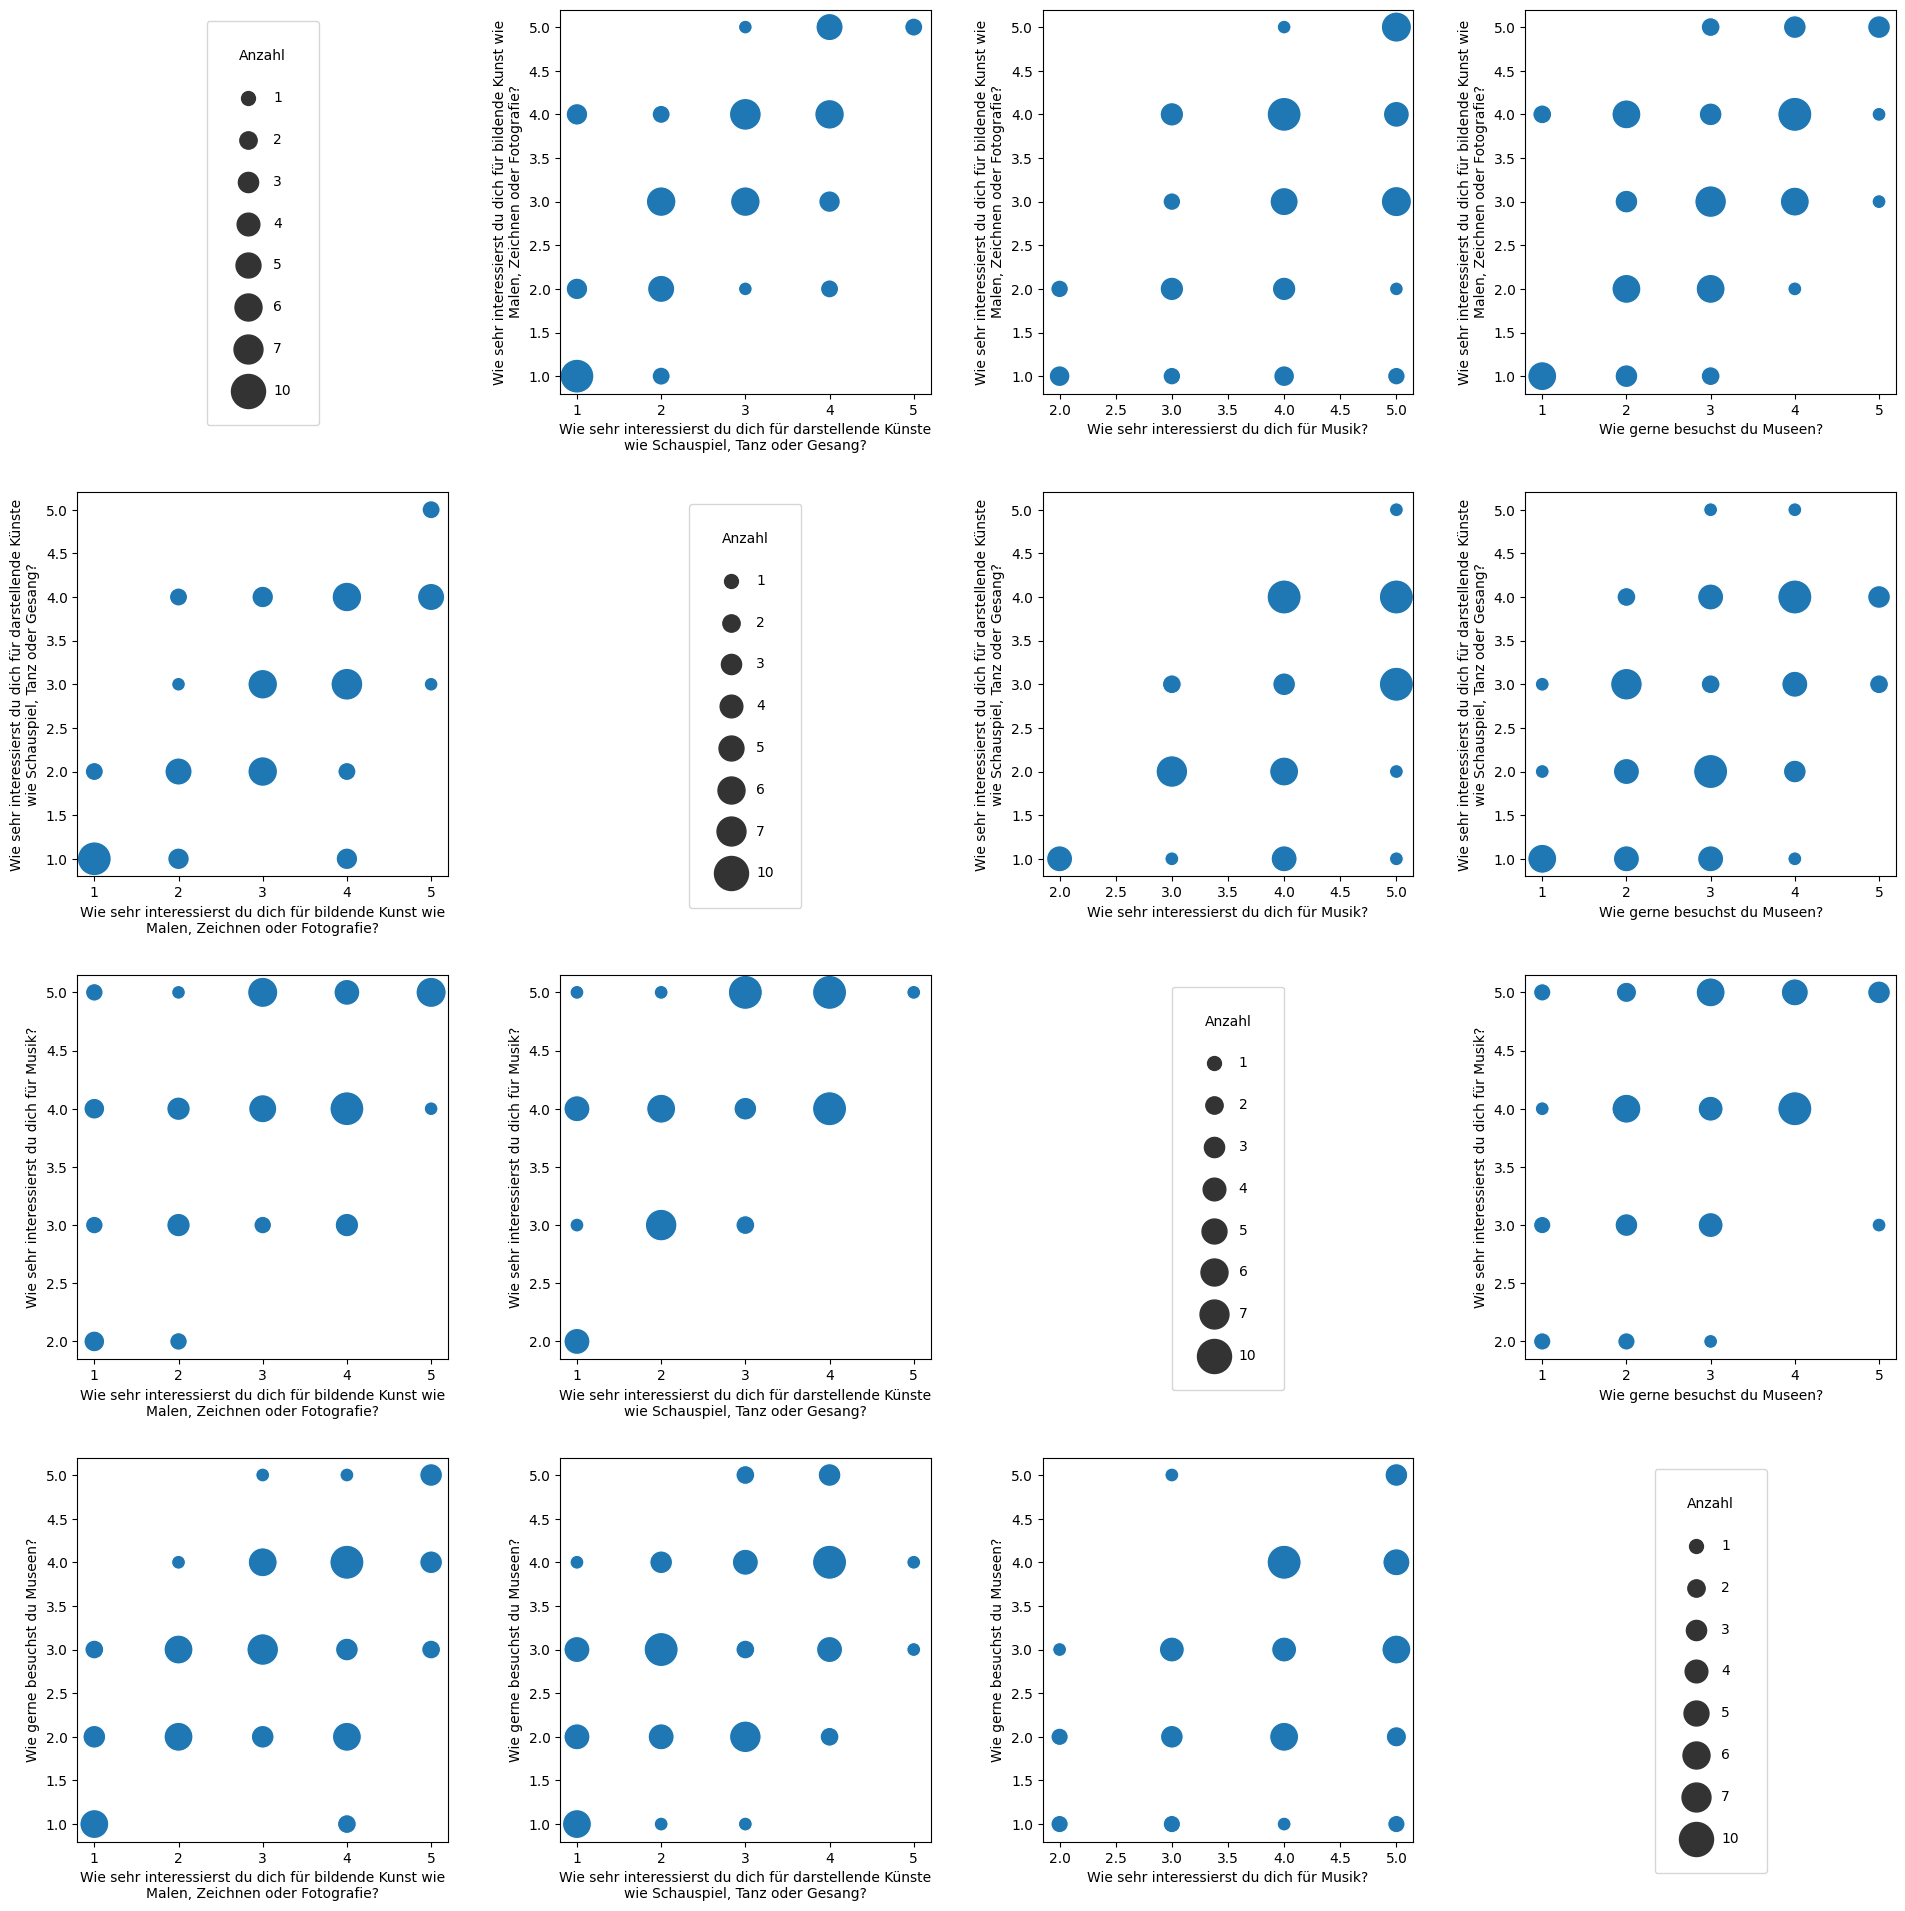

In [199]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.tight_layout(pad=5)

for idx1, col1 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
    for idx2, col2 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
        if col1 != col2:
            data_and_value_counts = pd.DataFrame(data[[col1, col2]].value_counts().sort_index()).reset_index()
            data_and_value_counts.columns = [col1, col2, 'count']
            # plot without legend because we only need it once per row
            sub_plt = sb.scatterplot(ax=axes[idx2, idx1], data=data_and_value_counts[[col1, col2]], legend=False,
                                    x=col1, y=col2, size=(data_and_value_counts['count']), sizes=(100, 600))
        else:
            # plot anyways but then hide anything but the legend
            data_and_value_counts = pd.DataFrame(data[[columns.musik, columns.museumsbesuche]].value_counts().sort_index()).reset_index()
            data_and_value_counts.columns = [columns.musik, columns.museumsbesuche, 'count']
            fake_plot = sb.scatterplot(ax=axes[idx2, idx1], data=data_and_value_counts[[columns.musik, columns.museumsbesuche]], legend="full",
                                    x=columns.musik, y=columns.museumsbesuche, size=(data_and_value_counts['count']), sizes=(100, 600))

            # adjust legend
            fake_plot.legend_.remove()
            fake_plot.legend(title="Anzahl" , loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=1, borderpad=2, labelspacing=2, fontsize=10)

            # remove everything but the legend                   
            axes[idx1,idx2].set_axis_off()
            for child in fake_plot.get_children():
                if not isinstance(child, matplotlib.legend.Legend):
                    child.set_visible(False)

#### Barplots derselben Feature-Paare ####

Es werden dieselben Features in Paar-Plots dargestellt, diesmal aber als Barplots. Dabei wird die Anzahl der Antworten auf der Y-Achse und eines der Features auf der X-Achse dargestellt. Das jeweils andere Features ist über die Farbe codiert. Jede Antwortmöglichkeit dieses Features erhält einen eigenen Balken. So kann aus dem Diagramm auch die generelle Verteilung der Antworten auf die Antwortmöglichkeiten grob abgelesen werden.

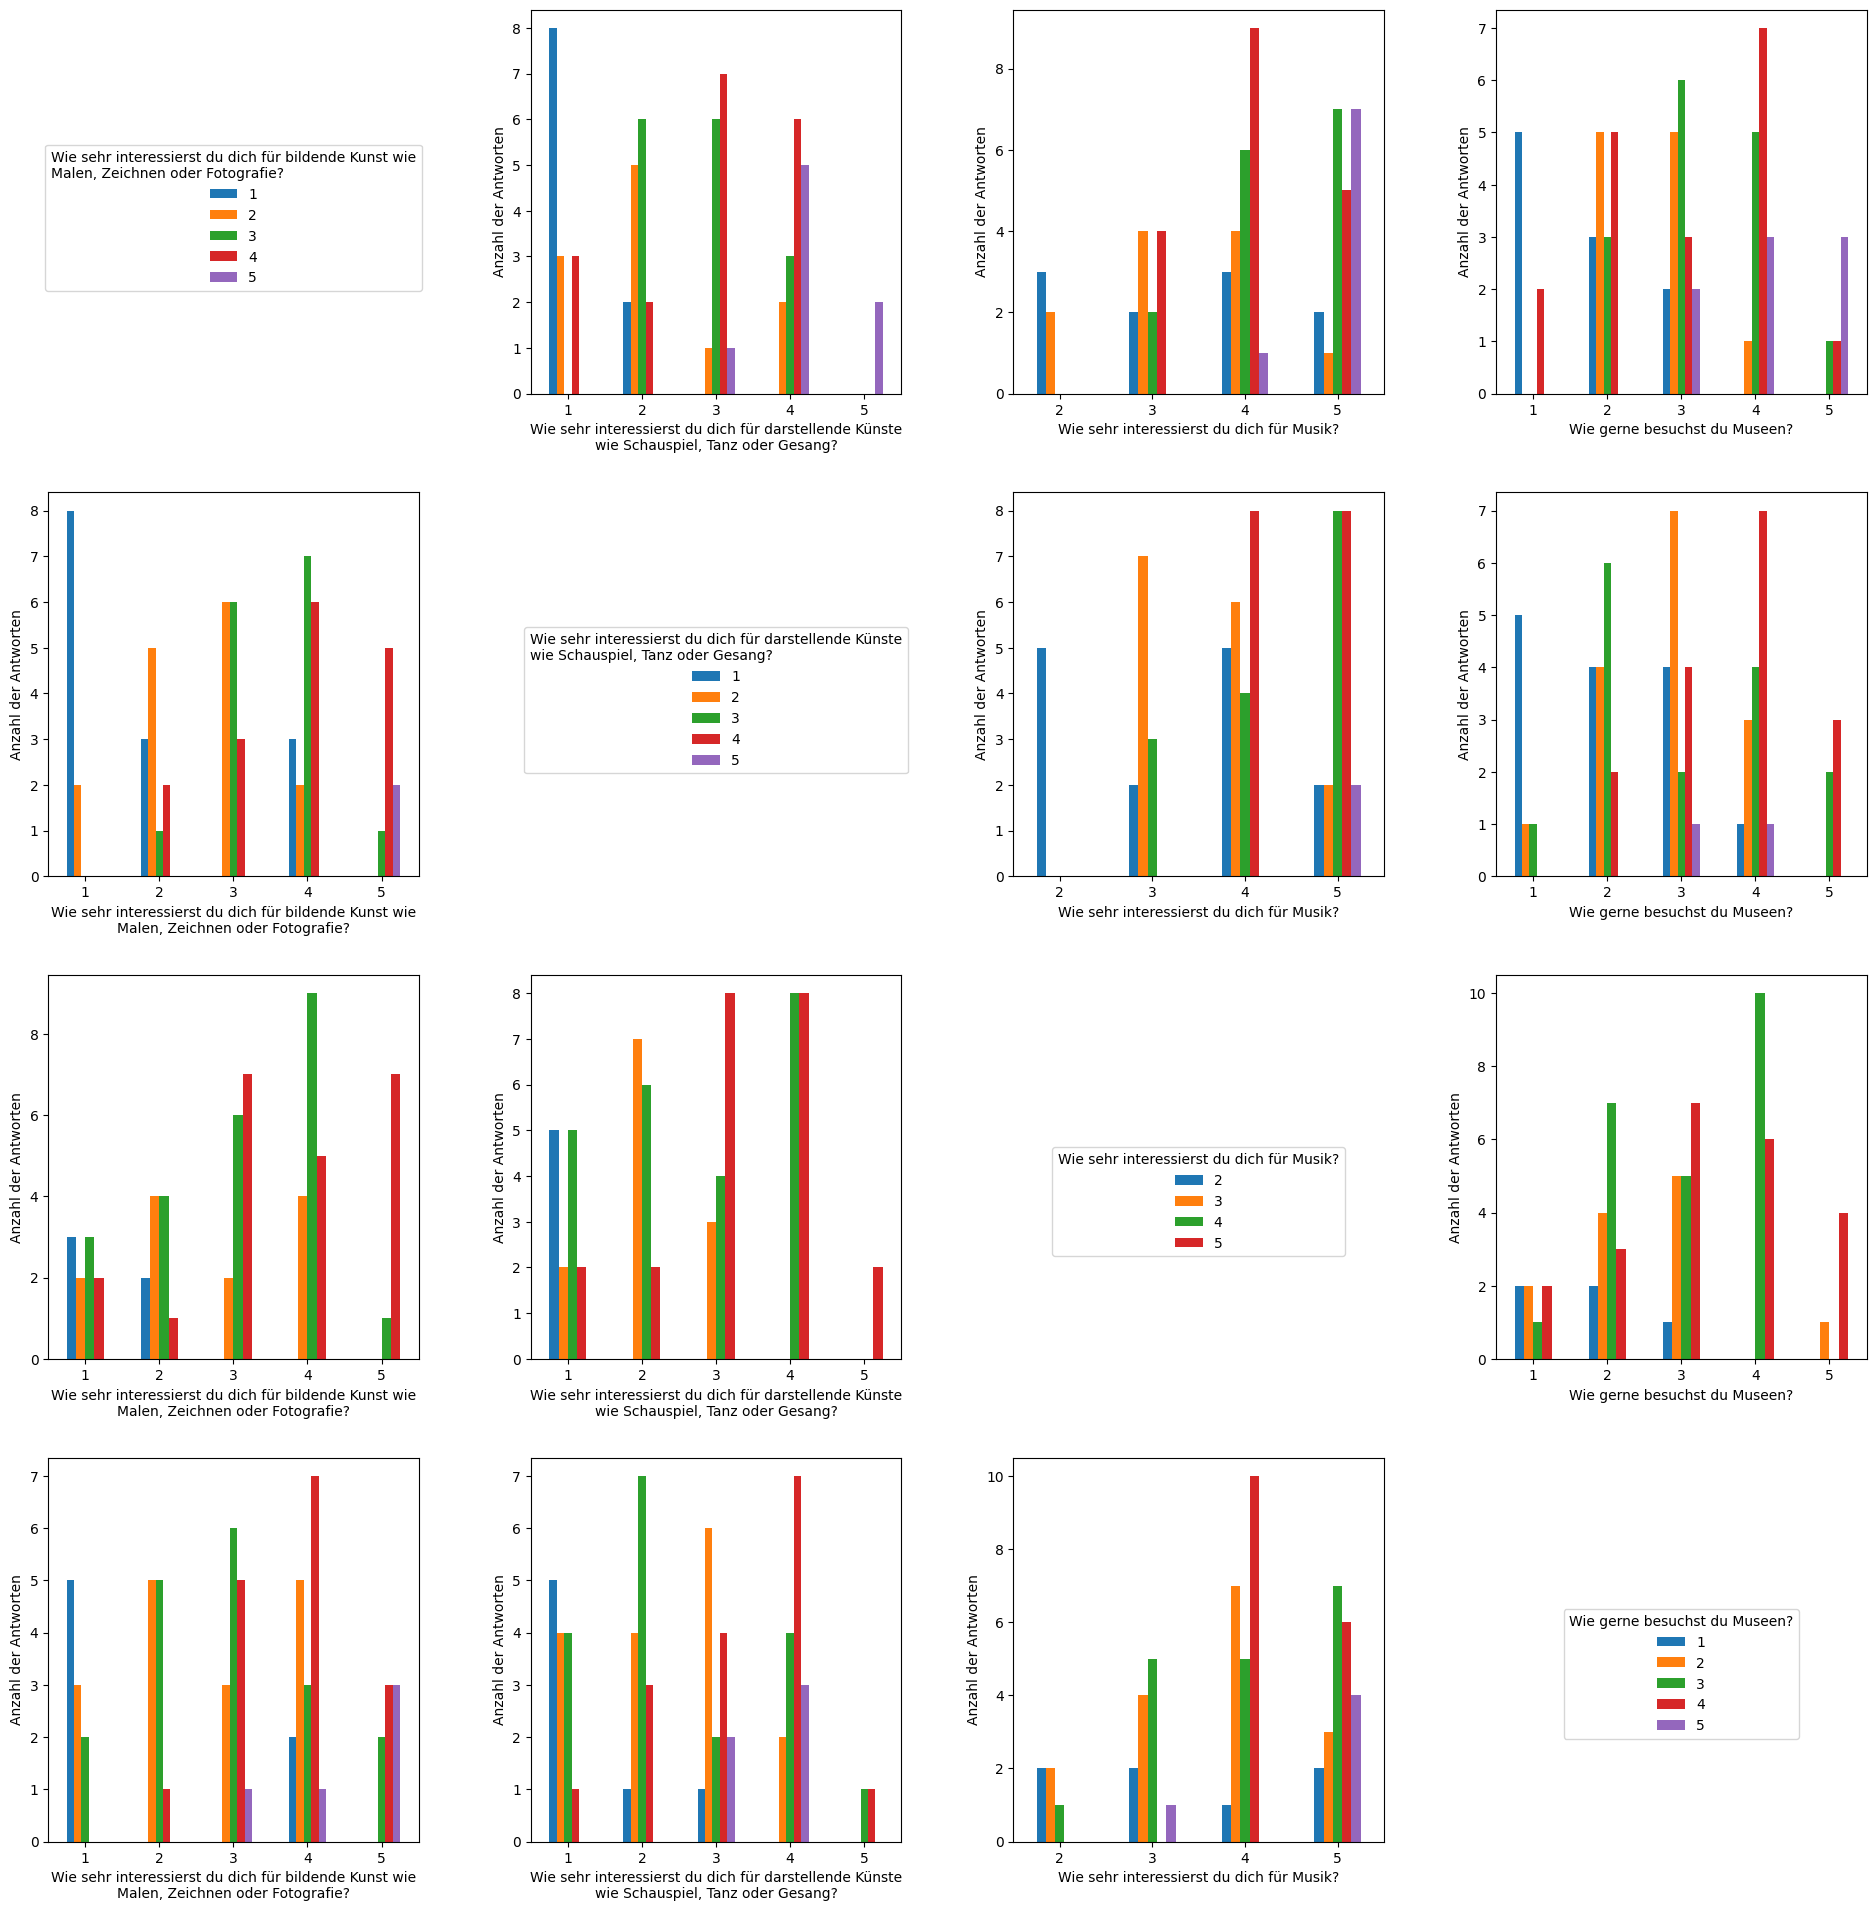

In [200]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.tight_layout(pad=5)

for idx1, col1 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
    for idx2, col2 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
        if col1 != col2:
            cross_tab = pd.crosstab(data[col1], data[col2])
            # plot without legend because we only need it once per row
            sub_plt = cross_tab.plot.bar(ax=axes[idx2, idx1], rot=0, ylabel="Anzahl der Antworten", legend=False)
        else:
            # plot anyways but then hide anything but the legend
            fake_cross_tab = pd.crosstab(data[col1], data[col2])
            fake_plot = fake_cross_tab.plot.bar(ax=axes[idx2, idx1], rot=0, ylabel="")
            axes[idx1,idx2].set_axis_off()
            for child in fake_plot.get_children():
                if not isinstance(child, matplotlib.legend.Legend):
                    child.set_visible(False)
            sb.move_legend(fake_plot, "lower center", bbox_to_anchor=(0.5, 0.25))

### 1.4.2 Alter vs. Sprachnachrichten <a name="1_4_2"></a>

Auffällig war die negative Korrelation von "Alter" und "Wie gerne magst du Sprachnachrichten". Daher werden die beiden Features noch einmal grafisch gegenübergestellt.

#### Swarmplot ####

Der Swarmplot zeigt jeweils die Anzahl der Antworten für eine bestimmte Kombination (jede Antwort als einzelner Punkt). Durch die Farbkodierung (eigene Farbe für jedes Alter) kann die Verteilung der Antworten für dieses Alter abgelesen werden.

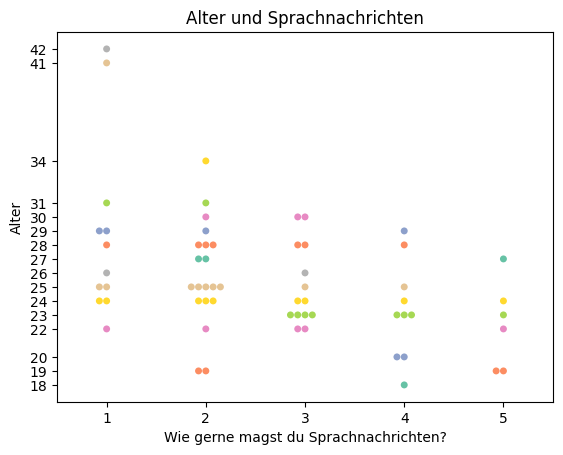

In [202]:
alter_sprachnachrichten_plt = sb.swarmplot(data=data, x=columns.sprachnachrichten, y=columns.alter, hue=columns.alter, palette="Set2", orient="v", legend=False)
alter_sprachnachrichten_plt.set_title("Alter und Sprachnachrichten")
alter_sprachnachrichten_plt.set_yticks(data[columns.alter].unique())

#### Barplot ####

Ähnlich wie beim Cluster rund um Kreativität wird als alternative Darstellungsvariante zusätzlich ein Barplot eingesetzt.

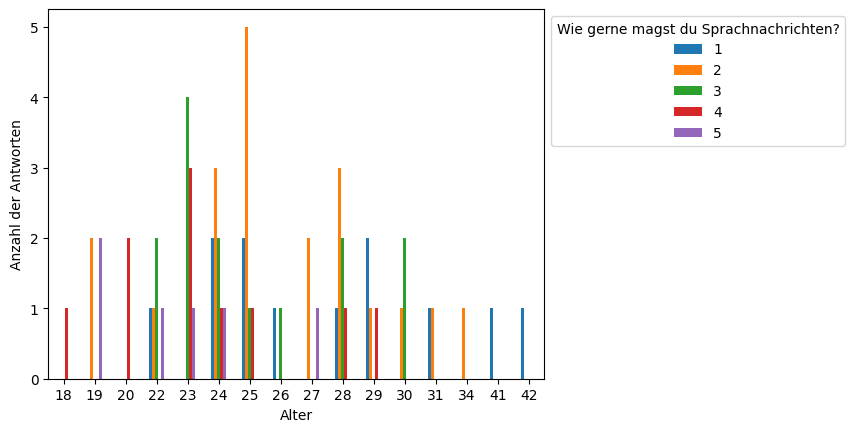

In [201]:
cross_tab = pd.crosstab(data[columns.alter], data[columns.sprachnachrichten])
ax = cross_tab.plot.bar(rot=0, ylabel="Anzahl der Antworten")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# 2. Korrelationsanalyse auf den vorverarbeiteten Daten *mit* Encoding <a name="2"></a>

## 2.1 _Einschub:_ Erkenntnisse vor Einbau des Variance-Filters <a name="2_1"></a>

Die ursprünglichen Ergebnisse der Korrelationsanalyse haben zusammen mit der Analyse der Daten im Preprocessing-Kapitel für den Einbau des Variance Filters gesorgt. Da sich die Ergebnisse der Korrelationsanalyse durch den Einbau des Filters wie erwartet verändert haben, werden die ursprünglichen Ergebnisse im folgenden zur besseren Nachvollziehbarkeit zusammengefasst:

Es fiel auf, dass zwischen den encodeten Features teilweise sehr hohe Korrelationen (~1) auftraten. Diese wurden durch die Berechnung der höchsten Korrelationen und anschließende Betrachtung einzelner Korrelationen näher analysiert.

Die höchsten Korrelationen fanden sich zwischen Features, die aus dem One-Hot-Encoding entstanden sind. Diese haben teilweise eine extrem niedrige Varianz, weil bspw. nur eine Person "True" als Wert hat und alle anderen "False". Wenn also genau eine Person als Lieblingssportart "Bogenschießen" und als Lieblingsessen "Gemüsepfanne Mit Reis" angegeben hat, korrelieren die Features dadurch sehr stark. Selbst, wenn Korrelationen von 1 außen vor gelassen wurden, zeigte sich ein ähnliches Bild.

## 2.2 Analyse der Korrelationen mit Encoding *und* Variance Filter <a name="2_2"></a>

<Axes: >

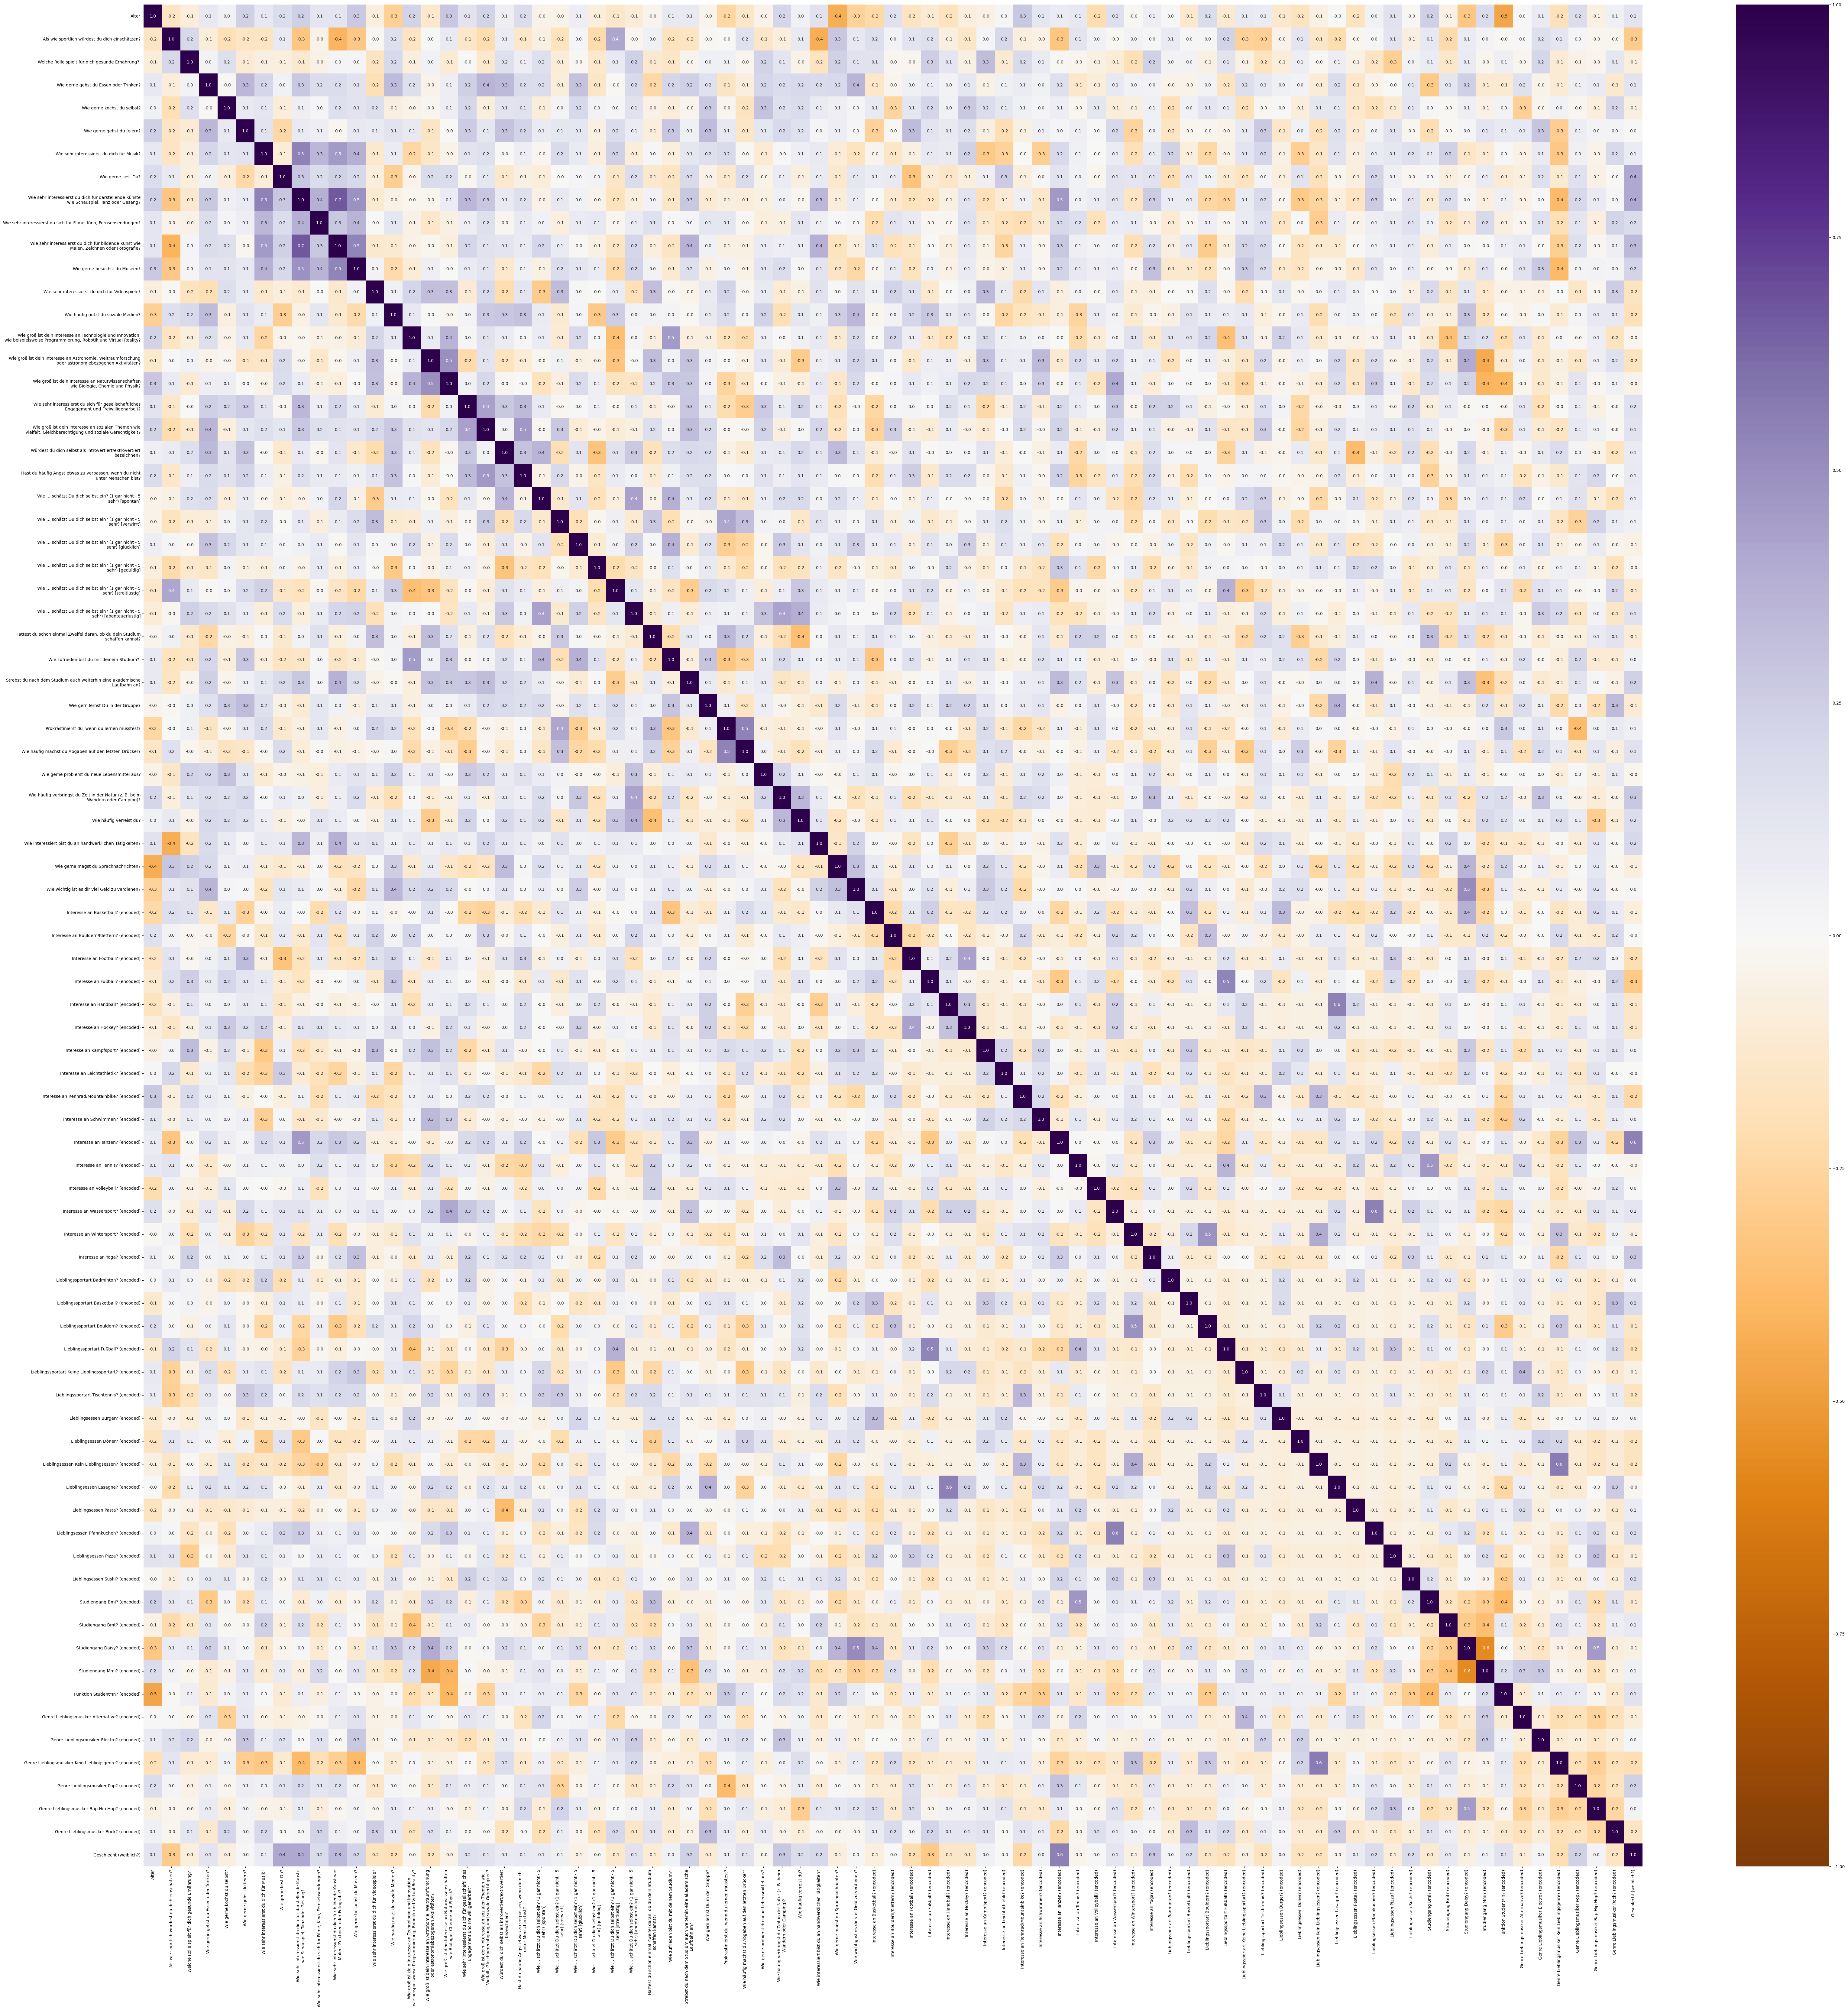

In [203]:
fig, ax = plt.subplots(figsize=(80, 80))

sb.heatmap(data_encoded.corr(numeric_only=True),
           annot=True, cmap="PuOr",fmt=".1f",
           vmin=-1, vmax=1)

Die Matrix ist durch die noch einmal erhöhte Feature-Anzahl noch schwerer ablesbar geworden. Es zeigt sich aber ein Cluster unten rechts in der Matrix, dass ggf. interessant sein könnte.

### 2.2.1 Ausschnitt der Matrix mit hoher Korrelation in den encodeten Features <a name="2_2_1"></a>

<Axes: >

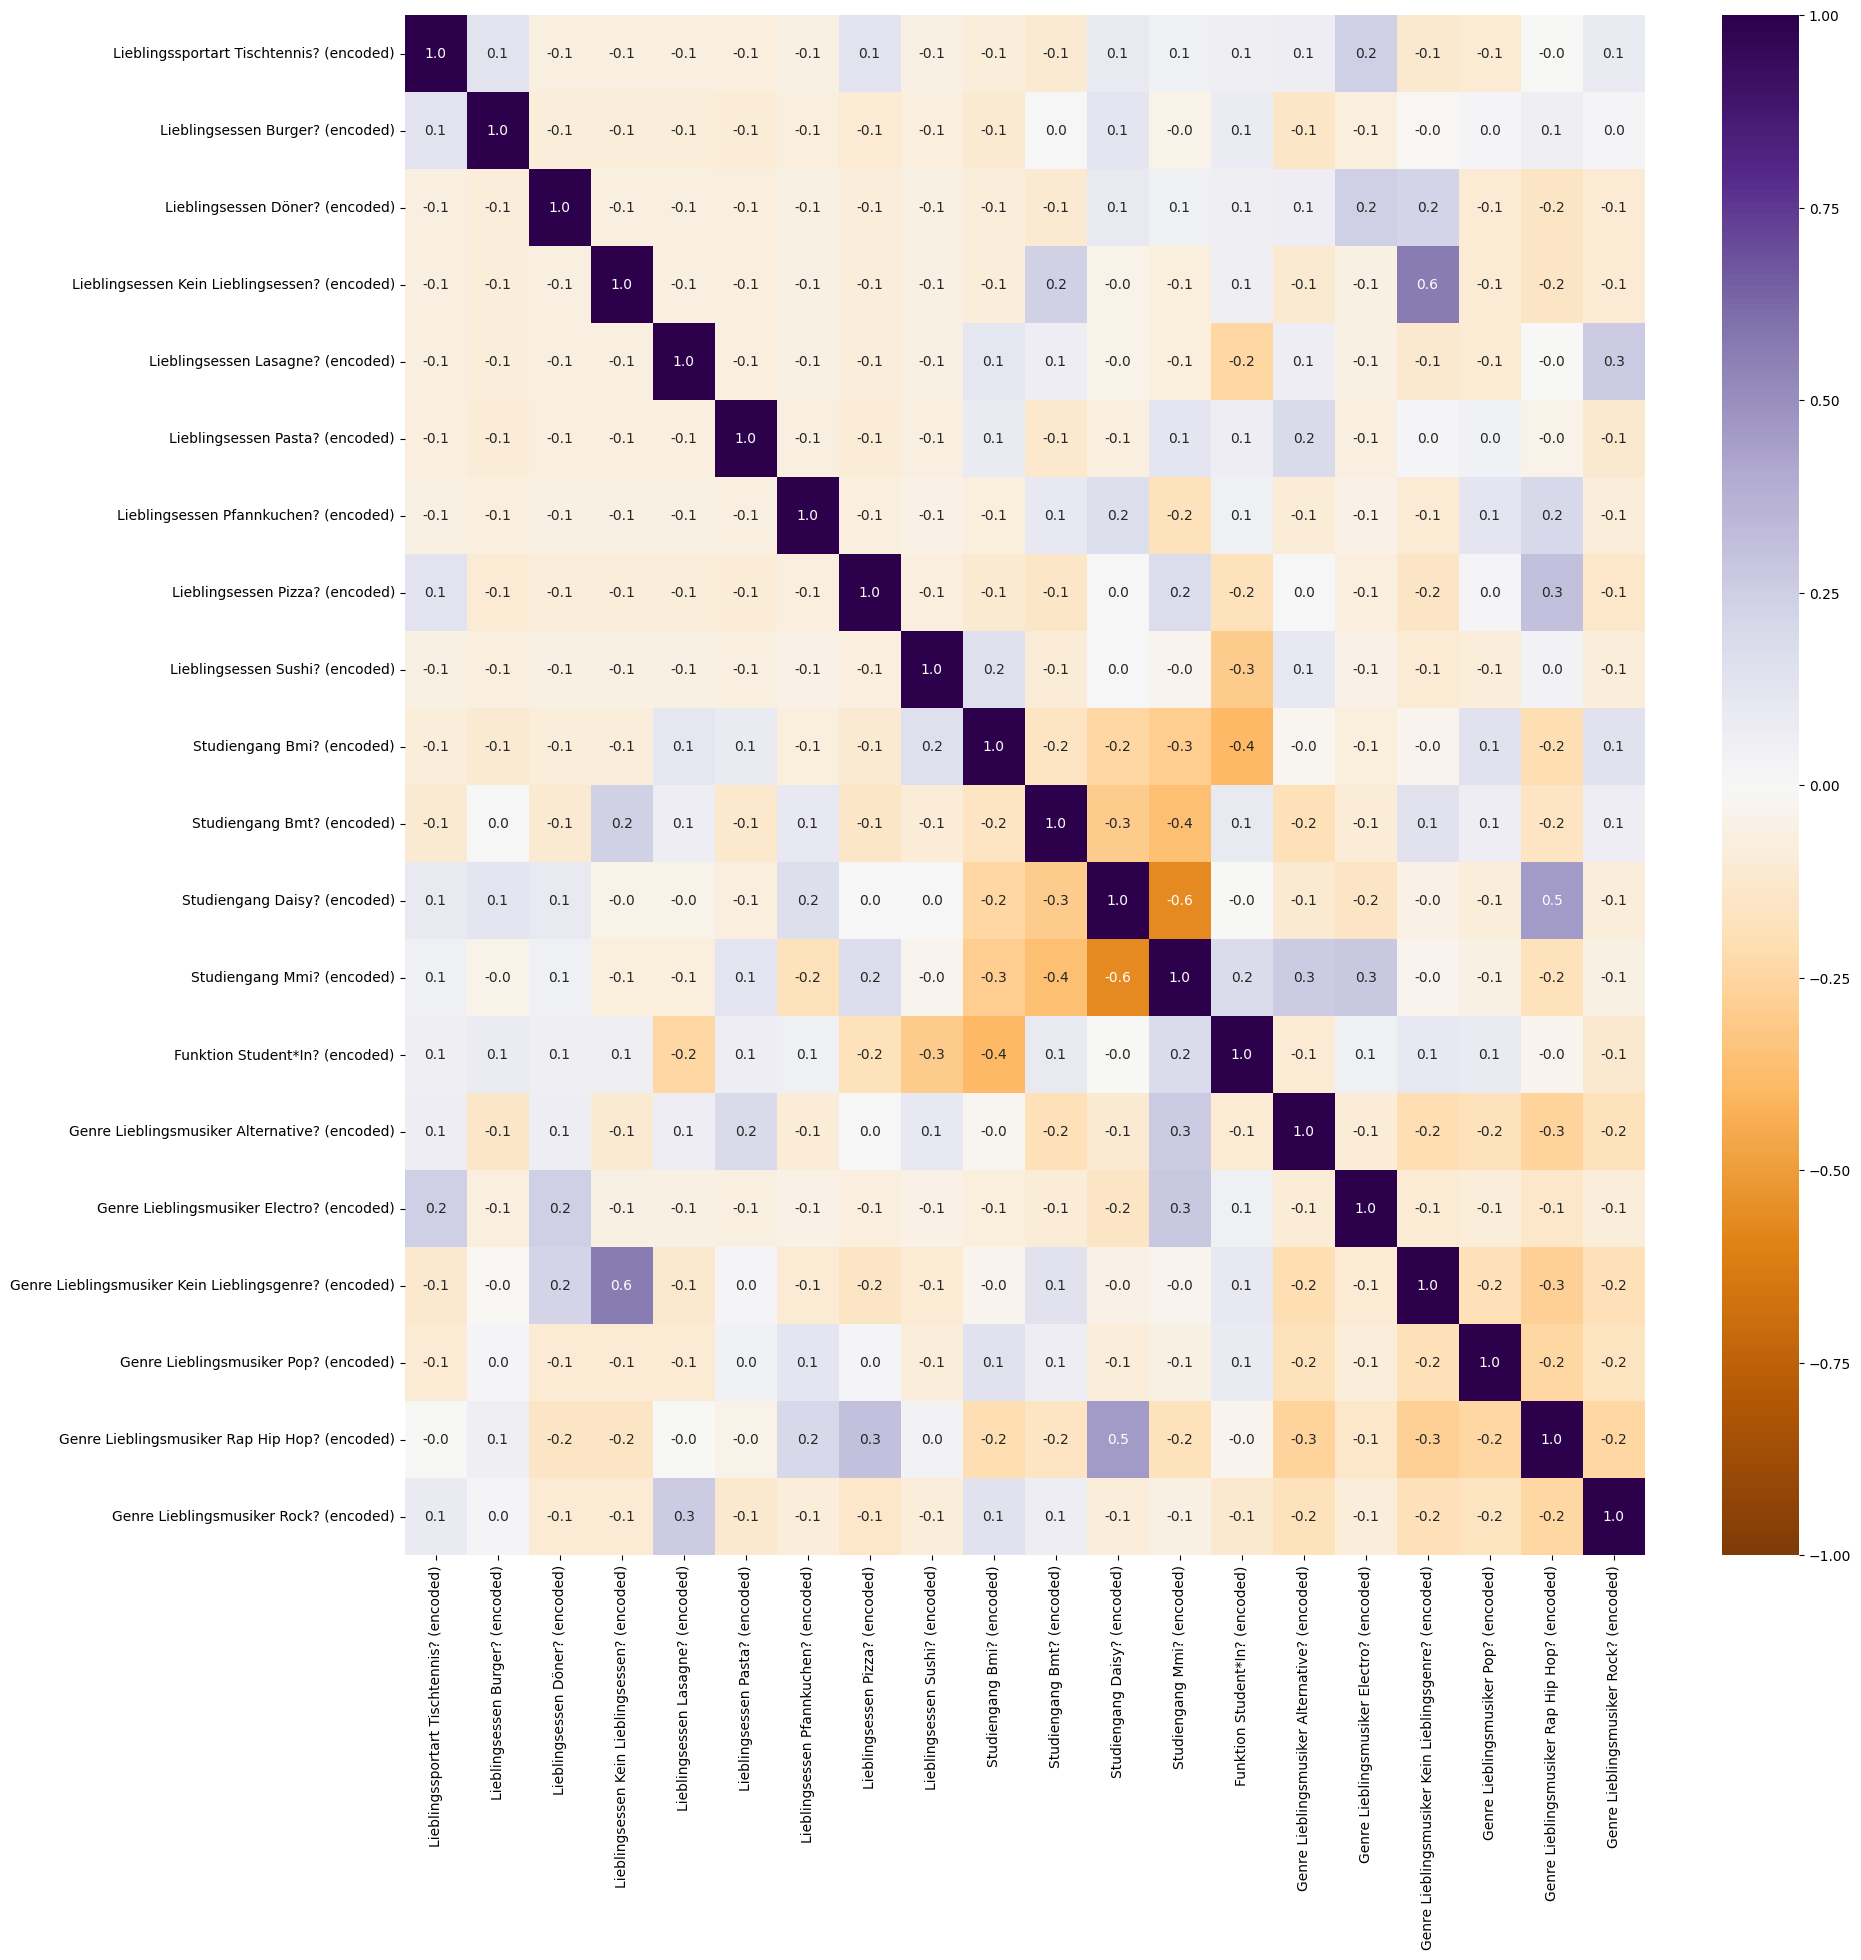

In [204]:
fig, ax = plt.subplots(figsize=(20, 20))

corr_matrix_encoded = data_encoded.corr(numeric_only=True)
sb.heatmap(corr_matrix_encoded.iloc[60:80, 60:80], annot=True, cmap="PuOr", fmt=".1f", vmin=-1, vmax=1)

"Lieblingsessen Kein Lieblingsessen? (encoded)" und	"Genre Lieblingsmusiker Kein Lieblingsgenre? (encoded)" korrelieren recht stark (0,6). Das spricht dafür, dass ein großer Teil der Befragten, die eins davon nicht angegeben haben auch das andere nicht angegeben haben bzw. bei beiden ungültige Werte eingetragen haben.

"Studiengang DAISY" und "Studiengang MMI" haben erwartungsgemäß eine hohe negative Korrelation (da davon ausgegangen werden kann, dass sich die beiden Antworten gegenseitig ausschließen).
# TODO: Warum ist die aber nicht noch höher? Und warum bei den anderen Studiengängen noch niedriger?

In [231]:
print(data_encoded[columns_encoded.studiengang_mmi].value_counts())
print(data_encoded[columns_encoded.studiengang_daisy].value_counts())
data_encoded[data_encoded[columns_encoded.studiengang_mmi] == 1][[columns_encoded.studiengang_mmi, columns_encoded.studiengang_daisy]]

Studiengang Mmi? (encoded)
False    37
True     25
Name: count, dtype: int64
Studiengang Daisy? (encoded)
False    42
True     20
Name: count, dtype: int64


Studiengang Mmi? (encoded)  Studiengang Daisy? (encoded)
0                         True                         False
1                         True                         False
2                         True                         False
3                         True                         False
4                         True                         False
5                         True                         False
6                         True                         False
7                         True                         False
19                        True                         False
20                        True                         False
25                        True                         False
26                        True                         False
27                        True                         False
28                        True                         False
29                        True                         False
30                        True                         False
32                        True                         False
40                        True                         False
44                        True                         False
49                        True                         False
50                        True                         False
51                        True                         False
52                        True                         False
56                        True                         False
57                        True                         False

### 2.2.2 Höchste (positive und negative) Korrelationen suchen <a name="2_2_2"></a>

In [205]:
correlations = data_encoded.corr(numeric_only=True)

# transform the correlation matrix into a dataframe with three columns
# this will create a row for each pair of columns with the correlation value as the third column
# based on https://stackoverflow.com/a/51071640
correlation_df = correlations.unstack().drop_duplicates().reset_index()
correlation_df.columns = ["column1", "column2", "correlation"]

# sort by correlation value
sorted_correlations = correlation_df.sort_values(by="correlation", ascending=False)
sorted_correlations.columns = ["column1", "column2", "correlation"]

# exclude all correlations with the same column
sorted_correlations = sorted_correlations[sorted_correlations["column1"] != sorted_correlations["column2"]]

# round the correlation values to one decimal place
sorted_correlations["correlation"] = sorted_correlations["correlation"].apply(lambda x: round(x, 1))

highest_and_lowest_correlations = pd.concat([sorted_correlations.head(15), sorted_correlations.tail(15)])

display(HTML(highest_and_lowest_correlations.to_html()))

Weitere hohe Korrelationen finden sich zwischen "Interesse an Wassersport? (encoded)"	und "Lieblingsessen Pfannkuchen? (encoded)"	(0,6) sowie zwischen "Interesse an Handball? (encoded)"	und "Lieblingsessen Lasagne? (encoded)"	(0,6). Es ist zu vermuten, dass beide Features eine niedrige Varianz aufweisen und daher so eine hohe Varianz zustande kommt. Um dies zu überprüfen, werden beide Kombinationen genauer untersucht:

In [226]:
print(data_encoded[columns_encoded.lieblingsessen_pfannkuchen].value_counts())
print(data_encoded[columns_encoded.sportarten_Wassersport].value_counts())
data_encoded[data_encoded[columns_encoded.sportarten_Wassersport] == 1][[columns_encoded.sportarten_Wassersport, columns_encoded.lieblingsessen_pfannkuchen]]

Lieblingsessen Pfannkuchen? (encoded)
False    59
True      3
Name: count, dtype: int64
Interesse an Wassersport? (encoded)
0    58
1     4
Name: count, dtype: int64


Interesse an Wassersport? (encoded)  Lieblingsessen Pfannkuchen? (encoded)
9                                     1                                  False
16                                    1                                   True
41                                    1                                  False
45                                    1                                   True

In [228]:
print(data_encoded[columns_encoded.lieblingsessen_lasagne].value_counts())
print(data_encoded[columns_encoded.sportarten_Handball].value_counts())
data_encoded[data_encoded[columns_encoded.lieblingsessen_lasagne] == 1][[columns_encoded.lieblingsessen_lasagne, columns_encoded.sportarten_Handball]]

Lieblingsessen Lasagne? (encoded)
False    58
True      4
Name: count, dtype: int64
Interesse an Handball? (encoded)
0    59
1     3
Name: count, dtype: int64


Lieblingsessen Lasagne? (encoded)  Interesse an Handball? (encoded)
2                                True                                 1
31                               True                                 0
34                               True                                 0
41                               True                                 1

Wie vermutet treten auch mit Variance Filter noch einige Kombinationen von Features auf, bei denen beide Features eine niedrige Varianz aufweisen und die eine hohe Korrelation haben. Es ist davon auszugehen, dass die Korrelation der Features bei einer höheren Datenmenge niedriger ausfallen würde (da kein inhaltlicher Zusammenhang der Features zu erkennen ist). Durch den Variance Filter fallen zumindest die Kombinationen, die eine extrem hohe Korrelation (~1) hatten, raus.

# TODO: Hier noch Plots für encodete Features und deren Korrelationen? #

z. B. welche mit starken Korrelationen

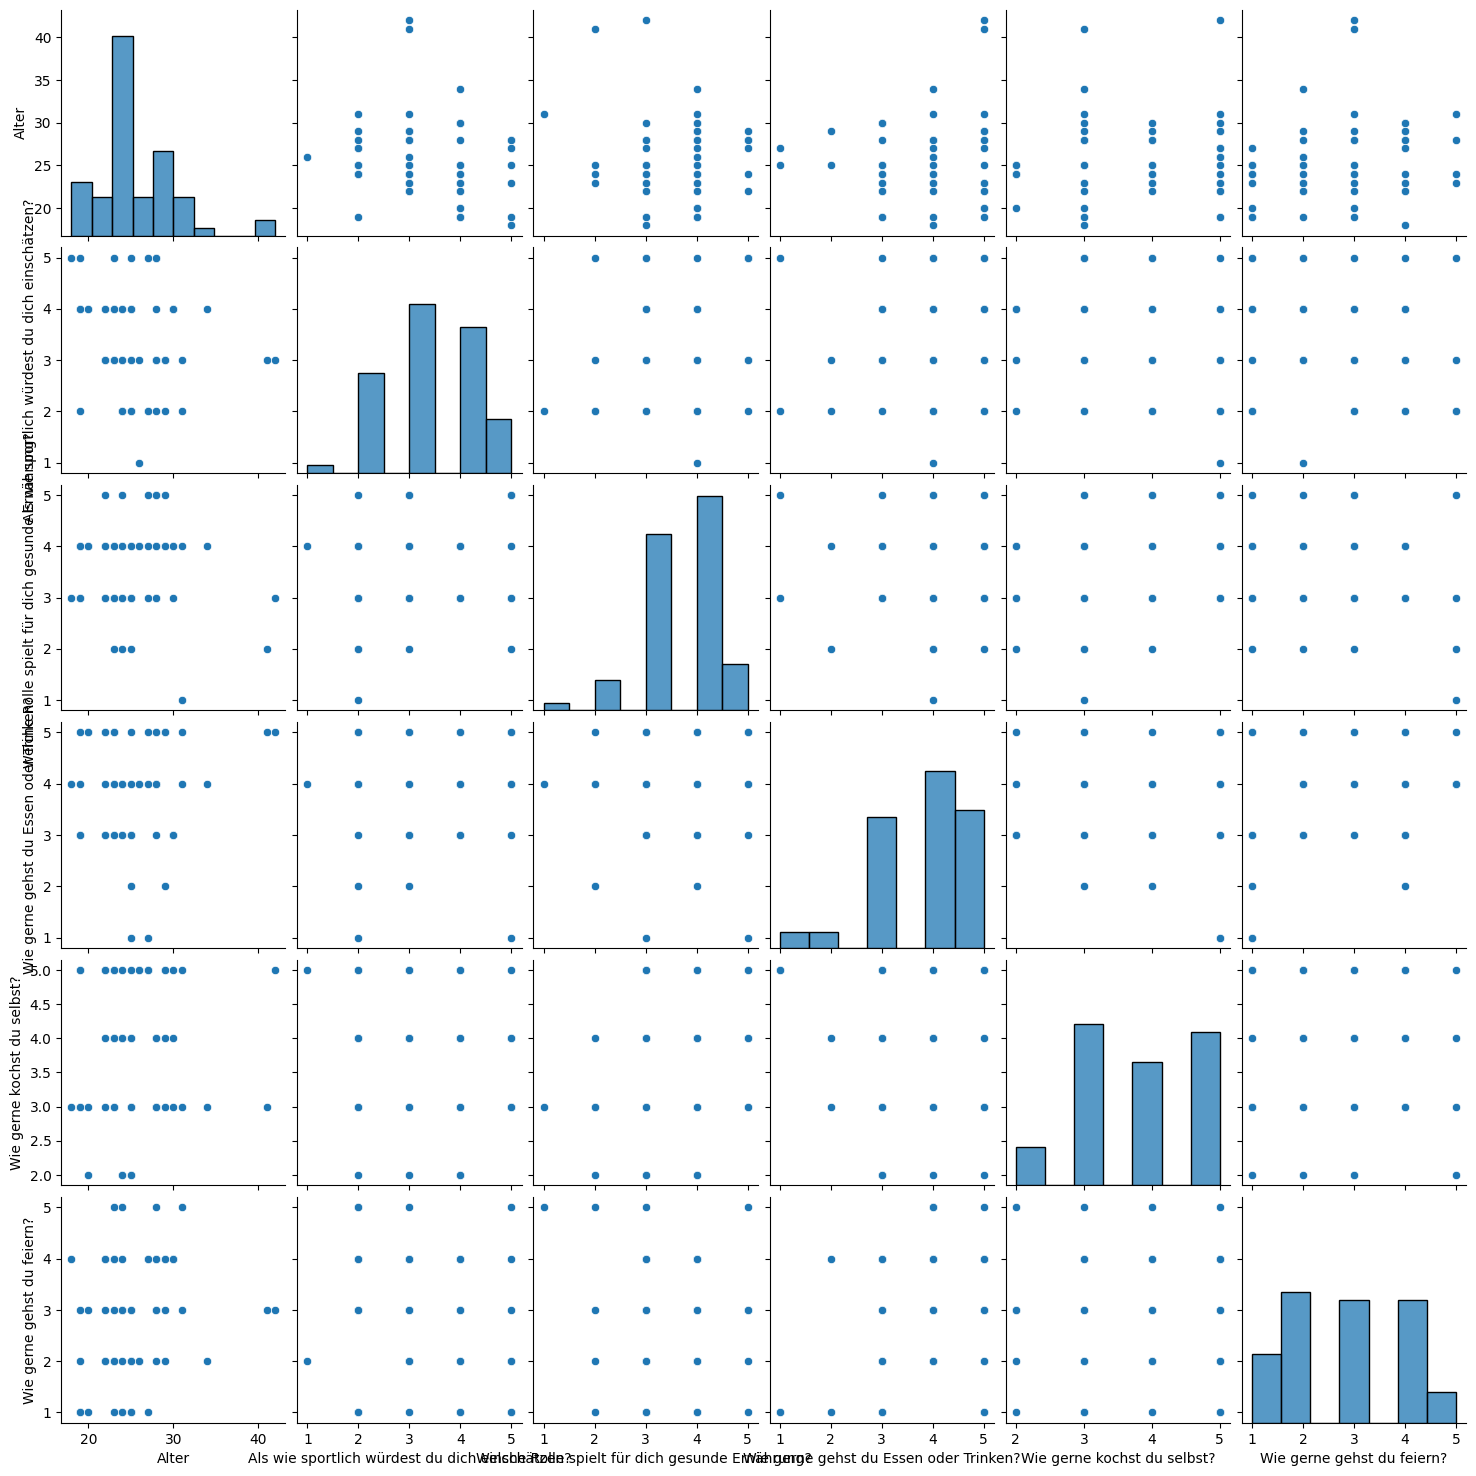

In [206]:
sb.pairplot(data.iloc[:,:10], diag_kind="hist")